# This notebook will compare attribution scores with ablation effects for neurons and residual stream dimensions.

We will
1) Do imports
2) Define model
3) Define dataset (we'll do this comparison on a single batch)
4) Compute attribution scores
5) Compute ablation effects
6) Compare the two





In [1]:
import argparse
import json
import os
os.environ['HF_HOME'] = '/om/user/ericjm/.cache/huggingface'
# os.environ['HF_HOME'] = os.environ.get('SCRATCH') + '/iaifi_lab/Lab/ericjm/.cache/huggingface'
from collections.abc import Mapping
from collections import defaultdict
from typing import Any, Dict, Tuple, Union
import copy

from tqdm.auto import tqdm
import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


/om2/user/ericjm/miniconda3/envs/narrow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def move_to_device(data: Any, device: torch.device) -> Any:
    """
    Recursively move tensors (or containers of tensors) to the specified device.
    """
    if isinstance(data, torch.Tensor):
        return data.to(device)
    if isinstance(data, Mapping):
        return type(data)({k: move_to_device(v, device) for k, v in data.items()})
    if isinstance(data, (list, tuple)):
        return type(data)(move_to_device(v, device) for v in data)
    return data

def prepare_data(
    dataset_name: str,
    model_name: str,
    max_length: int,
    batch_size: int,
    num_samples: int,
    split: str = "train",
    streaming: bool = True,
    skip_samples: int = 0,
) -> DataLoader:
    """
    Load and tokenize a dataset for pruning or evaluation.

    If the dataset is streamed, you can optionally skip a number of documents,
    allowing you to use one part of the stream for attribution and a different part for evaluation.
    
    Args:
        dataset_name: Name of the dataset to load.
        model_name: Name of the model used to load its tokenizer.
        max_length: Maximum token length.
        batch_size: Batch size to use in the DataLoader.
        num_samples: Number of samples to use from the dataset.
        split: Which split of the dataset to use (e.g. "train", "test").
        streaming: Whether to load the dataset in streaming mode.
        skip_samples: Number of samples to skip from the beginning of the stream.
    
    Returns:
        A DataLoader yielding batches suitable for language modeling.
    """
    if streaming:
        dataset = load_dataset(dataset_name, split=split, languages=['Python'], streaming=True)
        if skip_samples > 0:
            dataset = dataset.skip(skip_samples)
        dataset = dataset.take(num_samples)
        # Convert streaming dataset to a list to allow tokenization.
        dataset = list(dataset)
    else:
        dataset = load_dataset(dataset_name, split=split, languages=['Python'])
        # For non-streaming, we assume random access is available.
        dataset = dataset.select(range(skip_samples, skip_samples + num_samples))

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    def tokenize_function(examples):
        # Assumes the field "code" holds the text; adjust as necessary.
        return tokenizer(
            examples["code"],
            truncation=True,
            max_length=max_length,
        )

    tokenized_dataset = (
        dataset
        if isinstance(dataset, list)
        else dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
    )
    # If tokenized_dataset is a list (from streaming), tokenize each sample.
    if isinstance(tokenized_dataset, list):
        tokenized_dataset = [tokenize_function(sample) for sample in tokenized_dataset]

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    dataloader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=data_collator)
    return dataloader


@torch.no_grad()
def evaluate_model(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Dict[str, float]:
    """
    Evaluate the model on the provided data and compute average loss.
    
    Args:
        model: The language model to evaluate.
        dataloader: DataLoader providing evaluation batches.
        device: The device on which the model and data reside.
    
    Returns:
        A dictionary of evaluation statistics.
    """
    model.eval()
    losses = []
    for batch in tqdm(dataloader, desc="evaluating..."):
        batch = move_to_device(batch, device)
        outputs = model(**batch)
        losses.append(outputs.loss.item())
    return {
        "mean_loss": np.mean(losses).item(),
        "std_of_mean": (np.std(losses) / np.sqrt(len(losses))).item(),
        "losses": losses,
    }


def gradient_attribution(
    model: nn.Module,
    batch,
):
    """
    Args:
        model: The language model to prune.
        batch: A batch of data from a dataset.
    """
    model.train()  # Set to train mode to enable gradients
    model.zero_grad()
    batch = move_to_device(batch, model.device)
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    param_grads = {name: param.grad.detach() for name, param in model.named_parameters()}

    neuron_scores = {}
    for layeri, layer in enumerate(model.model.layers):
        gp_grad = param_grads[f"model.layers.{layeri}.mlp.gate_proj.weight"]
        up_grad = param_grads[f"model.layers.{layeri}.mlp.up_proj.weight"]
        dp_grad = param_grads[f"model.layers.{layeri}.mlp.down_proj.weight"]
        gp = layer.mlp.gate_proj.weight
        up = layer.mlp.up_proj.weight
        dp = layer.mlp.down_proj.weight
        neuron_scores[layeri] = torch.sum(
            (gp_grad * -gp) + 
            (up_grad * -up) + 
            (dp_grad.T * -dp.T), 
            dim=1
        ).abs().tolist()
    
    d_model = model.config.hidden_size
    device = model.model.embed_tokens.weight.device
    dtype = model.model.embed_tokens.weight.dtype
    residual_scores = torch.zeros(d_model, device=device, dtype=dtype)
    residual_scores += (param_grads[f"model.embed_tokens.weight"] * -model.model.embed_tokens.weight).sum(dim=0)
    for layeri, layer in enumerate(model.model.layers):
        residual_scores += param_grads[f"model.layers.{layeri}.input_layernorm.weight"] * -layer.input_layernorm.weight
        residual_scores += param_grads[f"model.layers.{layeri}.post_attention_layernorm.weight"] * -layer.post_attention_layernorm.weight
        residual_scores += (param_grads[f"model.layers.{layeri}.mlp.gate_proj.weight"] * -layer.mlp.gate_proj.weight).sum(dim=0)
        residual_scores += (param_grads[f"model.layers.{layeri}.mlp.up_proj.weight"] * -layer.mlp.up_proj.weight).sum(dim=0)
        residual_scores += (param_grads[f"model.layers.{layeri}.mlp.down_proj.weight"] * -layer.mlp.down_proj.weight).sum(dim=1)
        residual_scores += (param_grads[f"model.layers.{layeri}.self_attn.q_proj.weight"] * -layer.self_attn.q_proj.weight).sum(dim=0)
        residual_scores += (param_grads[f"model.layers.{layeri}.self_attn.k_proj.weight"] * -layer.self_attn.k_proj.weight).sum(dim=0)
        residual_scores += (param_grads[f"model.layers.{layeri}.self_attn.v_proj.weight"] * -layer.self_attn.v_proj.weight).sum(dim=0)
        residual_scores += (param_grads[f"model.layers.{layeri}.self_attn.o_proj.weight"] * -layer.self_attn.o_proj.weight).sum(dim=1)
    residual_scores += param_grads[f"model.norm.weight"] * -model.model.norm.weight
    residual_scores = residual_scores.abs().tolist()

    return neuron_scores, residual_scores


In [3]:
args = argparse.Namespace()
args.model_name = "NousResearch/Llama-3.2-1B"
args.dataset_name = "codeparrot/github-code"
args.max_length = 1024
args.batch_size = 8
args.accumulations = 4
args.streaming = True
args.prune_samples = 1000
args.prune_skip = 0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
print(f"Loading model: {args.model_name}")
model = AutoModelForCausalLM.from_pretrained(
    args.model_name,
    torch_dtype=torch.float32,
    device_map=str(device)
)

tokenizer = AutoTokenizer.from_pretrained(args.model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading model: NousResearch/Llama-3.2-1B


In [6]:
pruning_dataloader = prepare_data(
    dataset_name=args.dataset_name,
    model_name=args.model_name,
    max_length=args.max_length,
    batch_size=args.batch_size,
    num_samples=args.prune_samples,
    split="train",
    streaming=args.streaming,
    skip_samples=args.prune_skip
)

/om2/user/ericjm/miniconda3/envs/narrow/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for codeparrot/github-code contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/github-code
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
batch = next(iter(pruning_dataloader))

In [8]:
batch.input_ids.shape

torch.Size([8, 1024])

In [9]:
neuron_scores, residual_scores = gradient_attribution(model, batch)

Text(0.5, 1.0, 'Neuron scores')

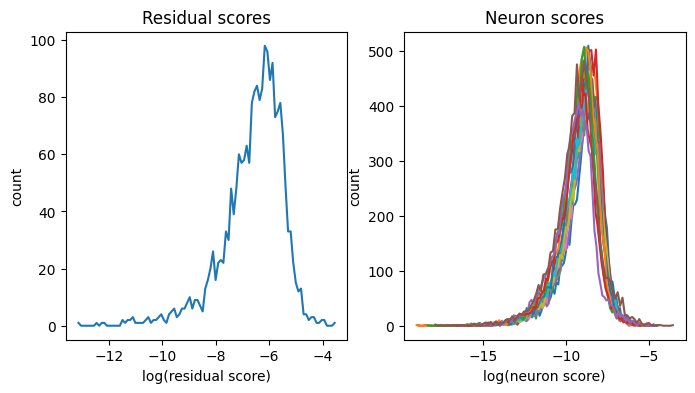

In [10]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
hist, bin_edges = np.histogram(np.log(residual_scores), bins=100)
plt.plot(bin_edges[:-1], hist)
plt.xlabel("log(residual score)")
plt.ylabel("count")
plt.title("Residual scores")

plt.subplot(1, 2, 2)
for layeri in range(len(neuron_scores)):
    hist, bin_edges = np.histogram(np.log(neuron_scores[layeri]), bins=100)
    plt.plot(bin_edges[:-1], hist)
plt.xlabel("log(neuron score)")
plt.ylabel("count")
plt.title("Neuron scores")

In [11]:
outputs = model(**batch.to(device))
original_loss = outputs.loss.item()

In [21]:
# compute residual stream ablation scores
residual_ablation_scores = np.zeros_like(residual_scores)
with torch.no_grad():
    for dimi in tqdm(range(len(residual_scores))):
        model_copy = copy.deepcopy(model)
        model_copy.to(device)
        model_copy.model.embed_tokens.weight[:, dimi] = 0
        for layeri, layer in enumerate(model_copy.model.layers):
            model_copy.model.layers[layeri].input_layernorm.weight[dimi] = 0
            model_copy.model.layers[layeri].post_attention_layernorm.weight[dimi] = 0
            model_copy.model.layers[layeri].mlp.gate_proj.weight[:, dimi] = 0
            model_copy.model.layers[layeri].mlp.up_proj.weight[:, dimi] = 0
            model_copy.model.layers[layeri].mlp.down_proj.weight[dimi, :] = 0
            model_copy.model.layers[layeri].self_attn.q_proj.weight[:, dimi] = 0
            model_copy.model.layers[layeri].self_attn.k_proj.weight[:, dimi] = 0
            model_copy.model.layers[layeri].self_attn.v_proj.weight[:, dimi] = 0
            model_copy.model.layers[layeri].self_attn.o_proj.weight[dimi, :] = 0
        model_copy.model.norm.weight[dimi] = 0
        # compute loss
        outputs = model_copy(**batch.to(device))
        loss = outputs.loss
        residual_ablation_scores[dimi] = np.abs(original_loss - loss.item())


100%|██████████| 2048/2048 [43:15<00:00,  1.27s/it]


In [32]:
(model_copy.model.norm.weight == 0).sum().item()

1

In [22]:
# save residual ablation scores
np.save("data/residual_ablation_scores.npy", residual_ablation_scores)

In [11]:
residual_ablation_scores = np.load("data/residual_ablation_scores.npy")

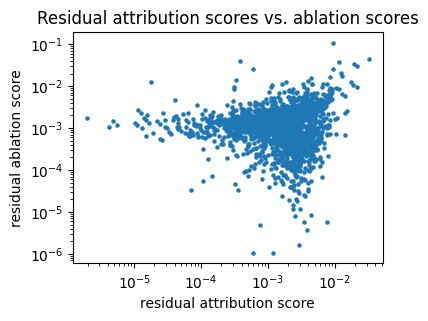

In [12]:
# plot residual attribution scores vs. ablation scores
plt.figure(figsize=(4, 3))
plt.scatter(residual_scores, residual_ablation_scores, s=5)
plt.xlabel("residual attribution score")
plt.ylabel("residual ablation score")
plt.title("Residual attribution scores vs. ablation scores")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [13]:
# compute correlation
corr, p_value = pearsonr(residual_scores, residual_ablation_scores)
print(f"Pearson r = {corr:.2f}, p-value = {p_value:.2e}")
corr, p_value = pearsonr(np.log(residual_scores), np.log(residual_ablation_scores))
print(f"Pearson r (log) = {corr:.2f}, p-value = {p_value:.2e}")

Pearson r = 0.39, p-value = 1.28e-73
Pearson r (log) = 0.05, p-value = 1.54e-02


Text(0.05, 0.85, 'Pearson r = 0.39')

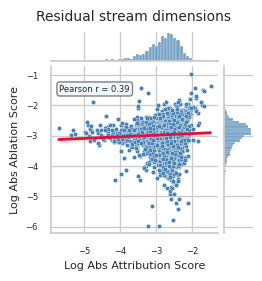

In [24]:
corr, p_value = pearsonr(residual_scores, residual_ablation_scores)

log_residual_scores = np.log10(residual_scores)
log_ablation_scores = np.log10(residual_ablation_scores)

sns.set(style="whitegrid", context="notebook")
joint_plot = sns.jointplot(
    x=log_residual_scores,
    y=log_ablation_scores,
    kind="scatter",
    height=2.75,
    color="steelblue",
    s=10, 
)

sns.regplot(
    x=log_residual_scores,
    y=log_ablation_scores,
    scatter=False,
    ax=joint_plot.ax_joint,
    line_kws={"color": "crimson", "lw": 2}
)

# Add text annotation for correlation and p-value
# joint_plot.ax_joint.text(0.05, 0.85, f'Pearson r = {corr:.2f}\np-value = {p_value:.2e}',
#                          transform=joint_plot.ax_joint.transAxes,
#                          fontsize=6,
#                          bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))

joint_plot.set_axis_labels('Log Abs Attribution Score', 'Log Abs Ablation Score', fontsize=8)
joint_plot.fig.suptitle('Residual stream dimensions', fontsize=10)
joint_plot.fig.subplots_adjust(top=0.9)

# Reduce tick fontsize
for ax in [joint_plot.ax_joint, joint_plot.ax_marg_x, joint_plot.ax_marg_y]:
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.annotate(f"Pearson r = {corr:.2f}",
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=6,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))


In [18]:
# sample 1000 (layer, neuron) pairs
neurons_to_ablate = []
for _ in range(500):
    layeri = np.random.randint(0, len(model.model.layers))
    neuroni = np.random.randint(0, model.config.intermediate_size)
    neurons_to_ablate.append((layeri, neuroni))

# save the neurons to ablate
import pickle
with open("data/neurons_to_ablate.pkl", "wb") as f:
    pickle.dump(neurons_to_ablate, f)

In [19]:
# compute neuron ablation scores
neuron_ablation_scores = []
with torch.no_grad():
    for layeri, neuroni in tqdm(neurons_to_ablate):
        model_copy = copy.deepcopy(model)
        model_copy.to(device)
        # ablate neuron
        model_copy.model.layers[layeri].mlp.gate_proj.weight[neuroni, :] = 0
        model_copy.model.layers[layeri].mlp.up_proj.weight[neuroni, :] = 0
        model_copy.model.layers[layeri].mlp.down_proj.weight[:, neuroni] = 0
        # compute loss
        outputs = model_copy(**batch.to(device))
        loss = outputs.loss
        neuron_ablation_scores.append(np.abs(original_loss - loss.item()))

100%|██████████| 500/500 [10:43<00:00,  1.29s/it]


In [20]:
# save neuron ablation scores
import pickle
with open("data/neuron_ablation_scores.pkl", "wb") as f:
    pickle.dump(neuron_ablation_scores, f)

In [14]:
import pickle
with open("data/neuron_ablation_scores.pkl", "rb") as f:
    neuron_ablation_scores = pickle.load(f)

with open("data/neurons_to_ablate.pkl", "rb") as f:
    neurons_to_ablate = pickle.load(f)


In [20]:
neuron_scores_selected = [neuron_scores[layeri][neuroni] for layeri, neuroni in neurons_to_ablate]
log_neuron_scores = np.log10(neuron_scores_selected)
log_ablation_scores = np.log10(neuron_ablation_scores)

nan_indices = np.where(np.isinf(log_neuron_scores) | np.isinf(log_ablation_scores))[0]
log_neuron_scores = np.delete(log_neuron_scores, nan_indices)
log_ablation_scores = np.delete(log_ablation_scores, nan_indices)

/tmp/ipykernel_3345558/1444780706.py:3: RuntimeWarning: divide by zero encountered in log10
  log_ablation_scores = np.log10(neuron_ablation_scores)


In [21]:
corr, p_value = pearsonr(neuron_scores_selected, neuron_ablation_scores)
print(f"Pearson r = {corr:.2f}, p-value = {p_value:.2e}")

corr, p_value = pearsonr(log_neuron_scores, log_ablation_scores)
print(f"Pearson r (log) = {corr:.2f}, p-value = {p_value:.2e}")


Pearson r = 0.44, p-value = 3.10e-25
Pearson r (log) = 0.80, p-value = 4.86e-111


In [22]:
from matplotlib.ticker import ScalarFormatter, LogFormatter, FuncFormatter
import matplotlib.ticker as ticker

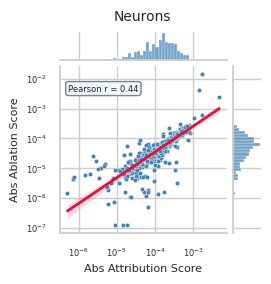

In [23]:
corr, p_value = pearsonr(neuron_scores_selected, neuron_ablation_scores)

sns.set(style="whitegrid", context="notebook")
joint_plot = sns.jointplot(
    x=log_neuron_scores,
    y=log_ablation_scores,
    kind="scatter",
    height=2.75,
    color="steelblue",
    s=10,
    marginal_kws=dict(bins=50)
)

sns.regplot(
    x=log_neuron_scores,
    y=log_ablation_scores,
    scatter=False,
    ax=joint_plot.ax_joint,
    line_kws={"color": "crimson", "lw": 2}
)

joint_plot.set_axis_labels('Abs Attribution Score', 'Abs Ablation Score', fontsize=8)
joint_plot.fig.suptitle('Neurons', fontsize=10)
joint_plot.fig.subplots_adjust(top=0.9)

def format_func(x, pos):
    return f'$10^{{{int(x)}}}$' if x == int(x) else f'$10^{{{x:.1f}}}$'

for ax in [joint_plot.ax_joint, joint_plot.ax_marg_x, joint_plot.ax_marg_y]:
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.annotate(f"Pearson r = {corr:.2f}",
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=6,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))

plt.savefig("figures/attribution-vs-ablation-neurons.pdf")

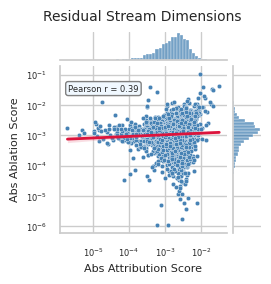

In [24]:
corr, p_value = pearsonr(residual_scores, residual_ablation_scores)

log_residual_scores = np.log10(residual_scores)
log_residual_ablation_scores = np.log10(residual_ablation_scores)

sns.set(style="whitegrid", context="notebook")
joint_plot = sns.jointplot(
    x=log_residual_scores,
    y=log_residual_ablation_scores,
    kind="scatter",
    height=2.75,
    color="steelblue",
    s=10,
    marginal_kws=dict(bins=50)
)

sns.regplot(
    x=log_residual_scores,
    y=log_residual_ablation_scores,
    scatter=False,
    ax=joint_plot.ax_joint,
    line_kws={"color": "crimson", "lw": 2}
)

joint_plot.set_axis_labels('Abs Attribution Score', 'Abs Ablation Score', fontsize=8)
joint_plot.fig.suptitle('Residual Stream Dimensions', fontsize=10)
joint_plot.fig.subplots_adjust(top=0.9)

def format_func(x, pos):
    return f'$10^{{{int(x)}}}$' if x == int(x) else f'$10^{{{x:.1f}}}$'

for ax in [joint_plot.ax_joint, joint_plot.ax_marg_x, joint_plot.ax_marg_y]:
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.annotate(f"Pearson r = {corr:.2f}",
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=6,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))

plt.savefig("figures/attribution-vs-ablation-residual.pdf")

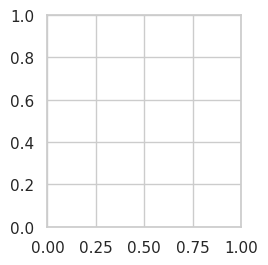

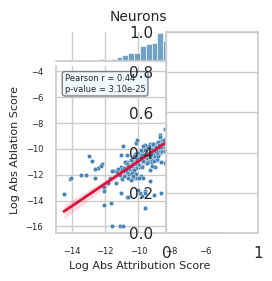

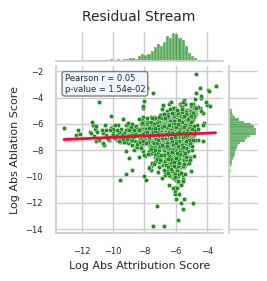

In [41]:
# Create jointplots for both neuron and residual stream correlations
plt.figure(figsize=(5.5, 2.75))

# First panel for neurons
plt.subplot(1, 2, 1)
joint_plot_neurons = sns.jointplot(
    x=log_neuron_scores,
    y=log_ablation_scores,
    kind="scatter",
    height=2.75,
    color="steelblue",
    s=10,  # Reduced scatter point size
)

# Add regression line with a different color
sns.regplot(
    x=log_neuron_scores,
    y=log_ablation_scores,
    scatter=False,
    ax=joint_plot_neurons.ax_joint,
    line_kws={"color": "crimson", "lw": 2}
)

# Set axis labels and title
joint_plot_neurons.set_axis_labels('Log Abs Attribution Score', 'Log Abs Ablation Score', fontsize=8)
joint_plot_neurons.fig.suptitle('Neurons', fontsize=10)
joint_plot_neurons.fig.subplots_adjust(top=0.9)

# Reduce tick fontsize
for ax in [joint_plot_neurons.ax_joint, joint_plot_neurons.ax_marg_x, joint_plot_neurons.ax_marg_y]:
    ax.tick_params(axis='both', which='major', labelsize=6)

# Display correlation coefficient
plt.annotate(f"Pearson r = {corr:.2f}\np-value = {p_value:.2e}",
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=6,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))


plt.subplot(1, 2, 2)
# Prepare residual stream data (assuming similar preprocessing as for neurons)
log_residual_scores = np.log(residual_scores)
log_residual_ablation_scores = np.log(residual_ablation_scores)

# Remove NaN or infinite values
nan_indices_residual = np.where(np.isinf(log_residual_scores) | np.isinf(log_residual_ablation_scores))[0]
log_residual_scores = np.delete(log_residual_scores, nan_indices_residual)
log_residual_ablation_scores = np.delete(log_residual_ablation_scores, nan_indices_residual)

# Compute Pearson correlation for residual stream
residual_corr, residual_p_value = pearsonr(log_residual_scores, log_residual_ablation_scores)

joint_plot_residual = sns.jointplot(
    x=log_residual_scores,
    y=log_residual_ablation_scores,
    kind="scatter",
    height=2.75,
    color="forestgreen",
    s=10,  # Reduced scatter point size
)

# Add regression line with a different color
sns.regplot(
    x=log_residual_scores,
    y=log_residual_ablation_scores,
    scatter=False,
    ax=joint_plot_residual.ax_joint,
    line_kws={"color": "crimson", "lw": 2}
)

# Set axis labels and title
joint_plot_residual.set_axis_labels('Log Abs Attribution Score', 'Log Abs Ablation Score', fontsize=8)
joint_plot_residual.fig.suptitle('Residual Stream', fontsize=10)
joint_plot_residual.fig.subplots_adjust(top=0.9)

# Reduce tick fontsize
for ax in [joint_plot_residual.ax_joint, joint_plot_residual.ax_marg_x, joint_plot_residual.ax_marg_y]:
    ax.tick_params(axis='both', which='major', labelsize=6)

# Display correlation coefficient
plt.annotate(f"Pearson r = {residual_corr:.2f}\np-value = {residual_p_value:.2e}",
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=6,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="aliceblue"))

# Save the figures
joint_plot_neurons.fig.savefig("figures/attribution_vs_ablation_neurons.pdf")
joint_plot_residual.fig.savefig("figures/attribution_vs_ablation_residual.pdf")
# plt.show()

In [ ]:

    
    # Load pruning data
    print("Preparing pruning data...")

    
    # Create mask based on attribution scores
    print("Creating pruning mask based on attribution scores...")
    num_attribution_batches = args.prune_samples // args.batch_size
    mask, pruning_stats = mask_by_gradient_attribution(
        model=model,
        dataloader=pruning_dataloader,
        neuron_sparsity=args.neuron_sparsity,
        residual_sparsity=args.residual_sparsity,
        num_attribution_batches=num_attribution_batches,
        output_dir=args.output_dir
    )
    
    # Save initial pruning statistics
    pruning_stats_file = os.path.join(args.output_dir, "pruning_stats.json")
    with open(pruning_stats_file, "w") as f:
        json.dump(pruning_stats, f, indent=4)
    print(f"Pruning statistics saved to {pruning_stats_file}")
    # save mask as a torch file
    mask_file = os.path.join(args.output_dir, "pruning_mask.pt")
    torch.save(mask, mask_file)
    
    # ===== STEP 2: TRAINING PHASE =====
    
    # Load tokenizer for training data preparation
    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token